In [2]:
import networkx as nx
import random
import time
import sqlite3
from collections import defaultdict

# Function to generate sample employee data
def generate_employees(num_employees):
    departments = ['GA', 'SALES', 'ENGINEERING']
    roles = ['Junior', 'Senior', 'Manager', 'Director']
    skills = ['Technical', 'Creative', 'Analytical', 'Communication', 'Leadership']
    employees = []
    for i in range(num_employees):
        employee = {
            'id': i,
            'name': f'Employee_{i}',
            'department': random.choice(departments),
            'years_experience': random.randint(1, 20),
            'role': random.choices(roles, weights=[4, 3, 2, 1])[0],
            'skills': random.sample(skills, k=random.randint(1, 3))
        }
        employees.append(employee)
    return employees

# Function to create a graph network
def create_graph_network(employees):
    G = nx.Graph()
    for employee in employees:
        G.add_node(employee['id'], **employee)
    
    # Add edges (relationships)
    for i in range(len(employees)):
        for j in range(i+1, len(employees)):
            if random.random() < 0.1:  # 10% chance of connection
                relationship = random.choice(['reporting', 'project', 'mentorship'])
                G.add_edge(employees[i]['id'], employees[j]['id'], relationship=relationship)
    
    return G

# Function to create a SQLite database
def create_database(employees):
    conn = sqlite3.connect(':memory:')
    c = conn.cursor()
    
    # Create tables
    c.execute('''CREATE TABLE employees
                 (id INTEGER PRIMARY KEY, name TEXT, department TEXT, years_experience INTEGER, role TEXT)''')
    c.execute('''CREATE TABLE skills
                 (employee_id INTEGER, skill TEXT, 
                 FOREIGN KEY(employee_id) REFERENCES employees(id))''')
    c.execute('''CREATE TABLE relationships
                 (employee1_id INTEGER, employee2_id INTEGER, relationship TEXT,
                 FOREIGN KEY(employee1_id) REFERENCES employees(id),
                 FOREIGN KEY(employee2_id) REFERENCES employees(id))''')
    
    # Insert data
    for employee in employees:
        c.execute("INSERT INTO employees VALUES (?, ?, ?, ?, ?)", 
                  (employee['id'], employee['name'], employee['department'], 
                   employee['years_experience'], employee['role']))
        for skill in employee['skills']:
            c.execute("INSERT INTO skills VALUES (?, ?)", (employee['id'], skill))
    
    conn.commit()
    return conn

# Demonstration functions
def graph_find_team_members(G, employee_id, max_depth=2):
    team = set()
    for depth in range(1, max_depth + 1):
        neighbors = set(nx.single_source_shortest_path(G, employee_id, cutoff=depth).keys())
        team.update(neighbors)
    team.remove(employee_id)  # Remove the employee themselves
    return team

def db_find_team_members(conn, employee_id, max_depth=2):
    c = conn.cursor()
    team = set()
    to_visit = {(employee_id, 0)}
    visited = set()

    while to_visit:
        current_id, depth = to_visit.pop()
        if current_id in visited or depth > max_depth:
            continue
        visited.add(current_id)
        if current_id != employee_id:
            team.add(current_id)
        
        if depth < max_depth:
            c.execute("""
                SELECT employee1_id, employee2_id FROM relationships 
                WHERE employee1_id = ? OR employee2_id = ?
            """, (current_id, current_id))
            for e1, e2 in c.fetchall():
                next_id = e2 if e1 == current_id else e1
                to_visit.add((next_id, depth + 1))
    
    return team

def graph_find_skill_clusters(G):
    skill_groups = defaultdict(list)
    for node, data in G.nodes(data=True):
        for skill in data['skills']:
            skill_groups[skill].append(node)
    return skill_groups

def db_find_skill_clusters(conn):
    c = conn.cursor()
    c.execute("SELECT employee_id, skill FROM skills")
    skill_groups = defaultdict(list)
    for employee_id, skill in c.fetchall():
        skill_groups[skill].append(employee_id)
    return skill_groups

def graph_find_central_employees(G):
    return sorted(nx.betweenness_centrality(G).items(), key=lambda x: x[1], reverse=True)[:5]

def db_find_central_employees(conn):
    c = conn.cursor()
    c.execute("SELECT employee1_id, COUNT(*) as connections FROM relationships GROUP BY employee1_id ORDER BY connections DESC LIMIT 5")
    return c.fetchall()

# Main demonstration
def run_demonstration():
    num_employees = 1000
    employees = generate_employees(num_employees)
    
    print("Creating graph network and database...")
    G = create_graph_network(employees)
    conn = create_database(employees)
    
    print("\nDemonstration 1: Finding team members")
    employee_id = random.choice(range(num_employees))
    
    start_time = time.time()
    graph_team = graph_find_team_members(G, employee_id)
    graph_time = time.time() - start_time
    
    start_time = time.time()
    db_team = db_find_team_members(conn, employee_id)
    db_time = time.time() - start_time
    
    print(f"Graph network found {len(graph_team)} team members in {graph_time:.4f} seconds")
    print(f"Database found {len(db_team)} team members in {db_time:.4f} seconds")
    
    print("\nDemonstration 2: Finding skill clusters")
    start_time = time.time()
    graph_skills = graph_find_skill_clusters(G)
    graph_time = time.time() - start_time
    
    start_time = time.time()
    db_skills = db_find_skill_clusters(conn)
    db_time = time.time() - start_time
    
    print(f"Graph network found skill clusters in {graph_time:.4f} seconds")
    print(f"Database found skill clusters in {db_time:.4f} seconds")
    
    print("\nDemonstration 3: Finding central employees")
    start_time = time.time()
    graph_central = graph_find_central_employees(G)
    graph_time = time.time() - start_time
    
    start_time = time.time()
    db_central = db_find_central_employees(conn)
    db_time = time.time() - start_time
    
    print(f"Graph network found central employees in {graph_time:.4f} seconds")
    print(f"Database found central employees in {db_time:.4f} seconds")
    
    conn.close()

if __name__ == "__main__":
    run_demonstration()

Creating graph network and database...

Demonstration 1: Finding team members
Graph network found 999 team members in 0.0000 seconds
Database found 0 team members in 0.0000 seconds

Demonstration 2: Finding skill clusters
Graph network found skill clusters in 0.0000 seconds
Database found skill clusters in 0.0000 seconds

Demonstration 3: Finding central employees
Graph network found central employees in 19.4267 seconds
Database found central employees in 0.0000 seconds


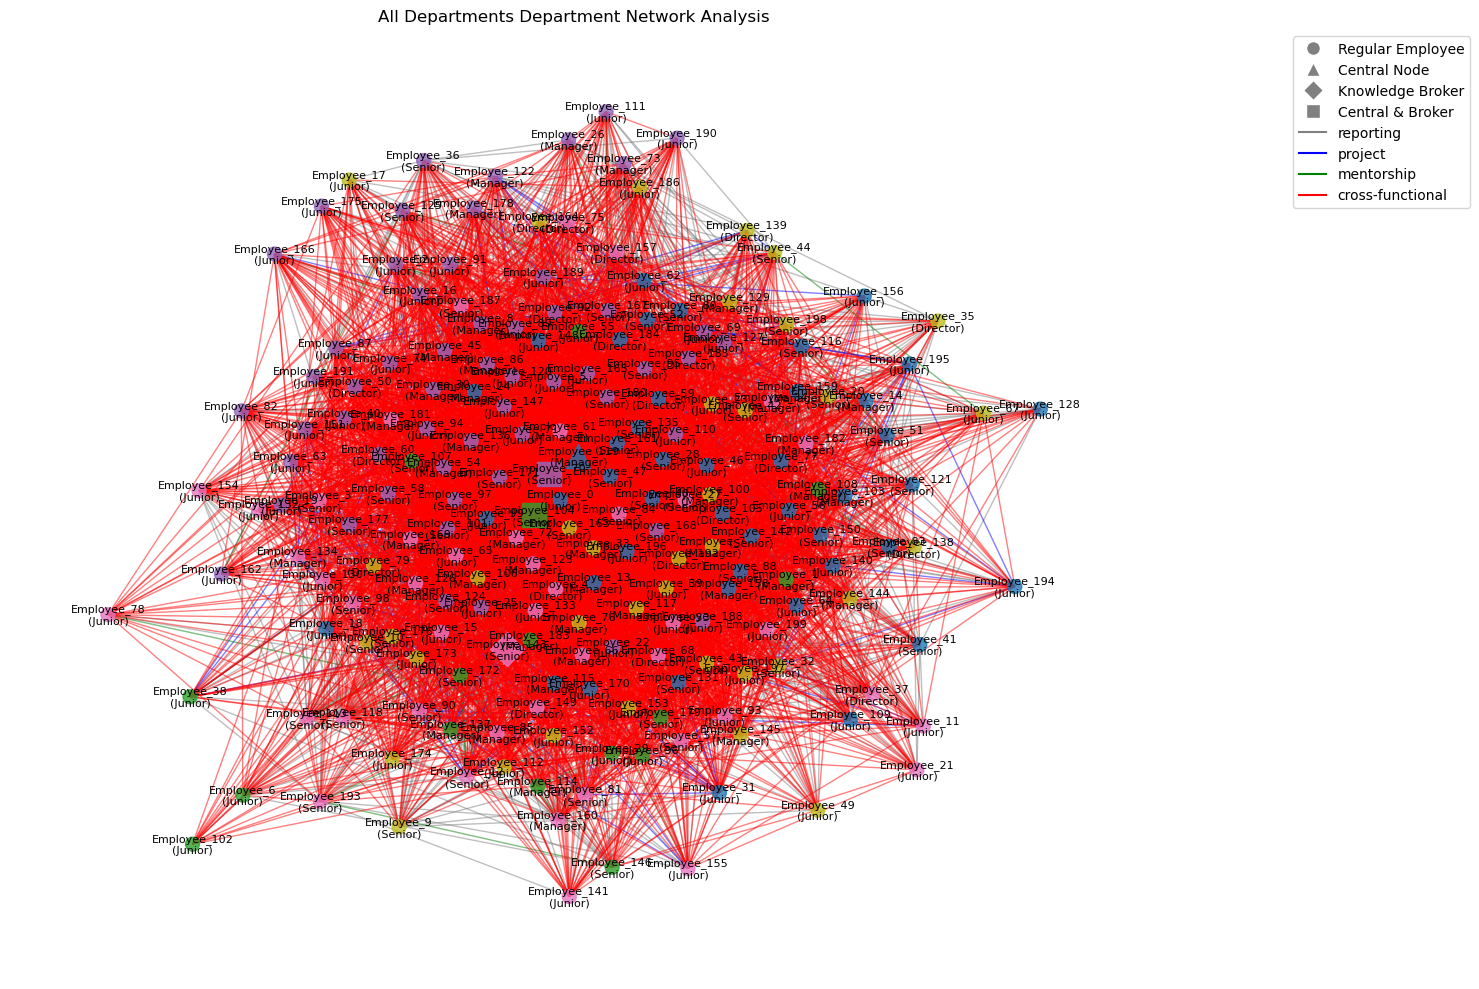


All Departments Department Analysis:

Central Nodes (High Degree Centrality):
Employee_104 - Role: Senior - Years: 8
Employee_70 - Role: Senior - Years: 6
Employee_119 - Role: Manager - Years: 18

Knowledge Brokers (High Betweenness Centrality):
Employee_104 - Role: Senior - Years: 8
Employee_70 - Role: Senior - Years: 6
Employee_143 - Role: Senior - Years: 3

Cluster Analysis:

Cluster 2 - Size: 57
Role Distribution:
  Junior: 30 (52.6%)
  Senior: 13 (22.8%)
  Manager: 10 (17.5%)
  Director: 4 (7.0%)

Cluster 0 - Size: 45
Role Distribution:
  Junior: 17 (37.8%)
  Senior: 16 (35.6%)
  Manager: 8 (17.8%)
  Director: 4 (8.9%)

Cluster 3 - Size: 45
Role Distribution:
  Junior: 14 (31.1%)
  Senior: 13 (28.9%)
  Manager: 12 (26.7%)
  Director: 6 (13.3%)

Cluster 4 - Size: 37
Role Distribution:
  Junior: 12 (32.4%)
  Senior: 10 (27.0%)
  Manager: 9 (24.3%)
  Director: 6 (16.2%)

Cluster 1 - Size: 16
Role Distribution:
  Junior: 6 (37.5%)
  Manager: 5 (31.2%)
  Senior: 5 (31.2%)

Relationshi

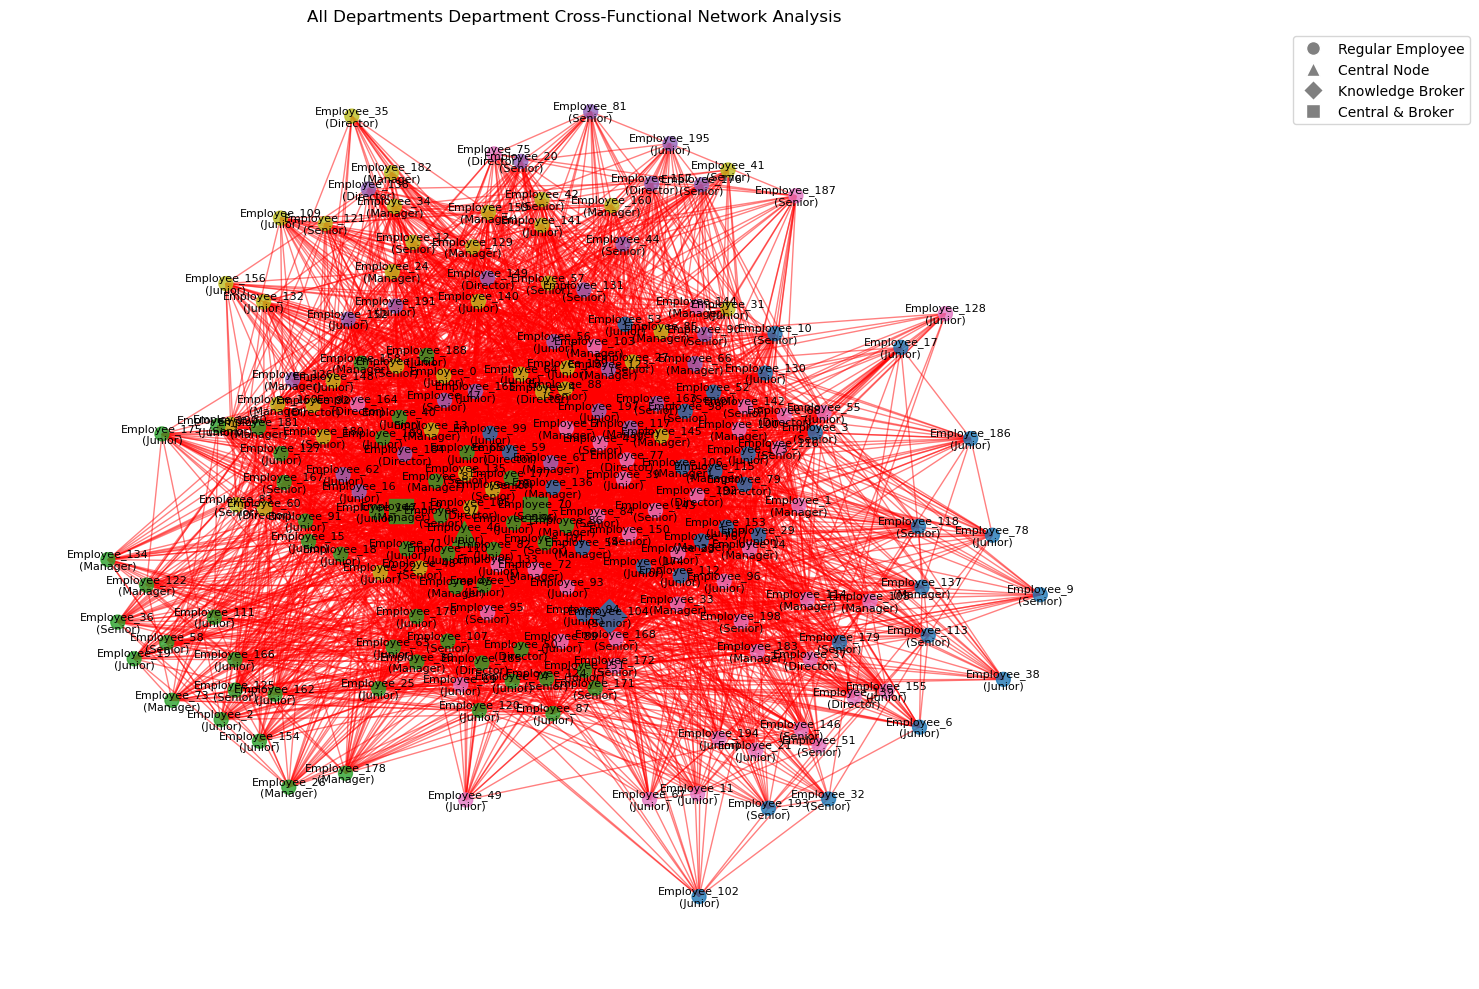


All Departments Department Cross-Functional Network Analysis:

Central Nodes (High Degree Centrality):
Employee_46 - Role: Junior - Years: 5 - Skills: Leadership, Analytical, Technical
Employee_70 - Role: Senior - Years: 6 - Skills: Leadership, Communication, Technical
Employee_119 - Role: Manager - Years: 18 - Skills: Leadership, Technical, Analytical

Knowledge Brokers (High Betweenness Centrality):
Employee_104 - Role: Senior - Years: 8 - Skills: Technical, Communication, Analytical
Employee_70 - Role: Senior - Years: 6 - Skills: Leadership, Communication, Technical
Employee_119 - Role: Manager - Years: 18 - Skills: Leadership, Technical, Analytical

Cluster Analysis:

Cluster 1 - Size: 55
Role Distribution:
  Junior: 30 (54.5%)
  Manager: 12 (21.8%)
  Senior: 11 (20.0%)
  Director: 2 (3.6%)
Skill Distribution:
  Technical: 55 (100.0%)
  Communication: 19 (34.5%)
  Creative: 14 (25.5%)
  Analytical: 12 (21.8%)
  Leadership: 11 (20.0%)

Cluster 3 - Size: 46
Role Distribution:
  Juni

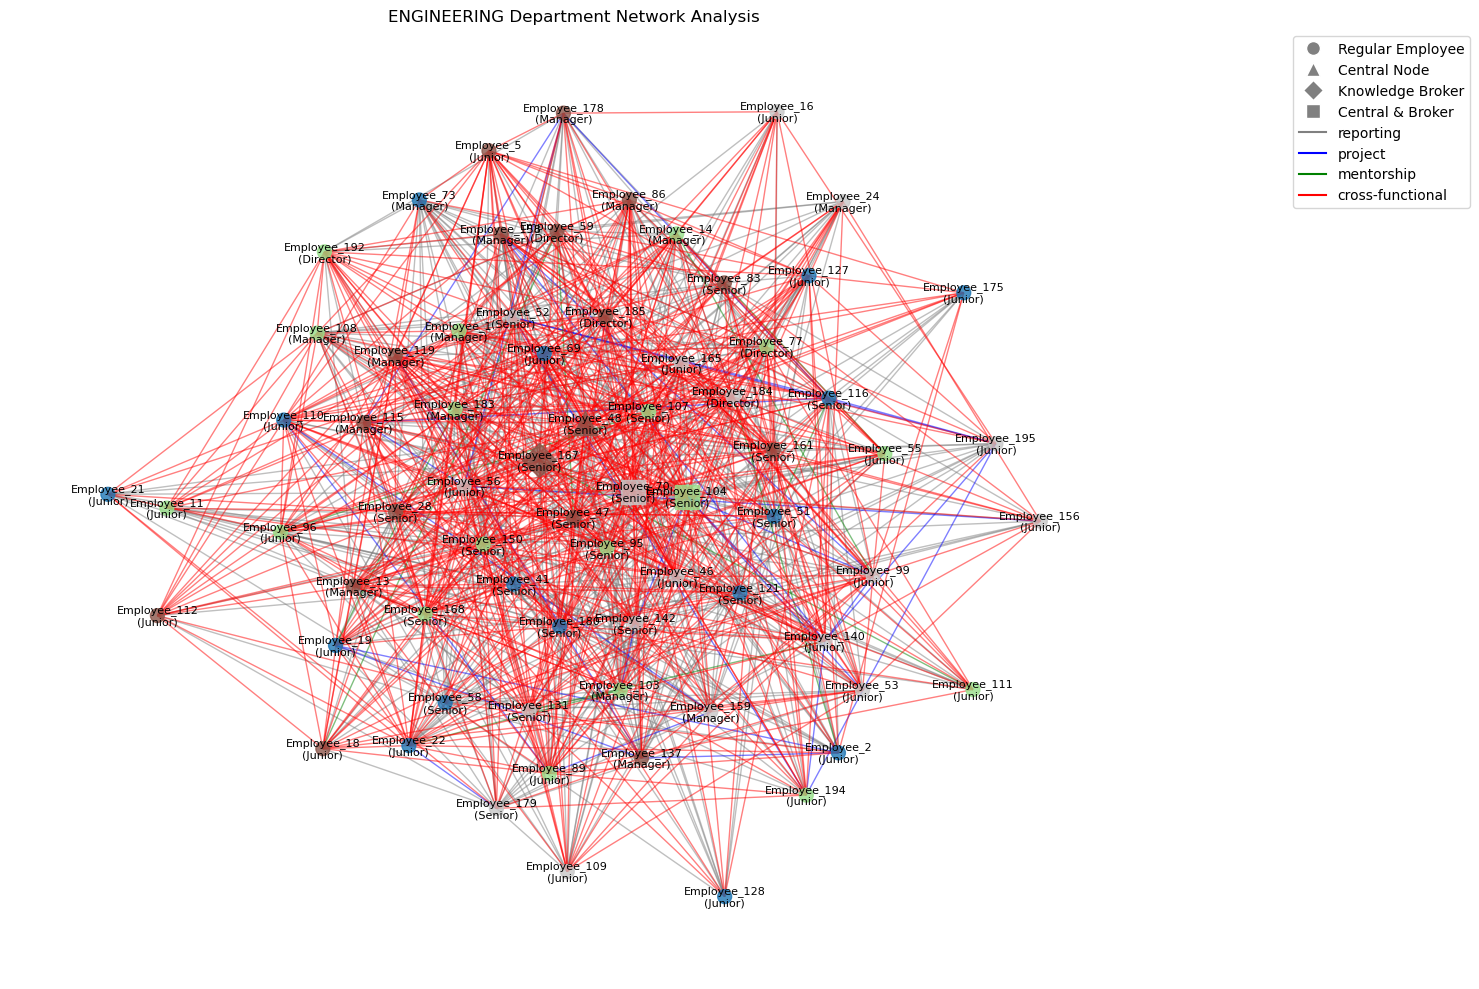


ENGINEERING Department Analysis:

Central Nodes (High Degree Centrality):
Employee_104 - Role: Senior - Years: 8
Employee_48 - Role: Senior - Years: 9
Employee_70 - Role: Senior - Years: 6

Knowledge Brokers (High Betweenness Centrality):
Employee_104 - Role: Senior - Years: 8
Employee_70 - Role: Senior - Years: 6
Employee_167 - Role: Senior - Years: 8

Cluster Analysis:

Cluster 1 - Size: 18
Role Distribution:
  Junior: 6 (33.3%)
  Manager: 5 (27.8%)
  Senior: 5 (27.8%)
  Director: 2 (11.1%)

Cluster 3 - Size: 18
Role Distribution:
  Junior: 10 (55.6%)
  Senior: 5 (27.8%)
  Manager: 2 (11.1%)
  Director: 1 (5.6%)

Cluster 2 - Size: 18
Role Distribution:
  Manager: 7 (38.9%)
  Senior: 6 (33.3%)
  Junior: 3 (16.7%)
  Director: 2 (11.1%)

Cluster 0 - Size: 16
Role Distribution:
  Junior: 9 (56.2%)
  Senior: 6 (37.5%)
  Manager: 1 (6.2%)

Relationship Type Analysis:
Reporting: 386
Project: 29
Mentorship: 11
Cross-functional: 602


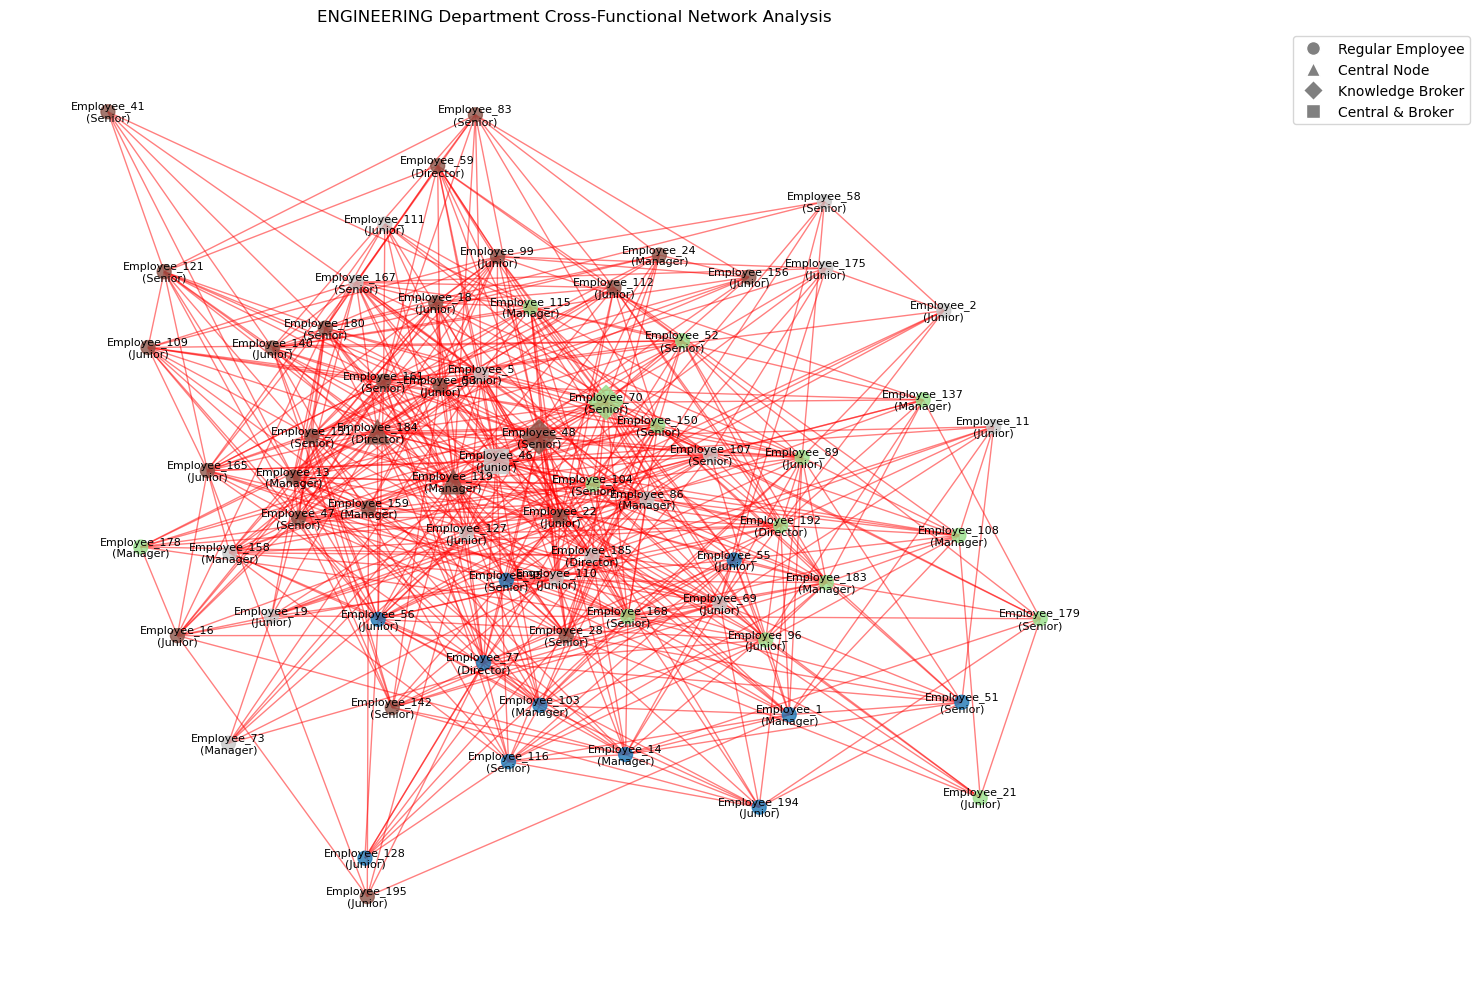


ENGINEERING Department Cross-Functional Network Analysis:

Central Nodes (High Degree Centrality):
Employee_184 - Role: Director - Years: 20 - Skills: Leadership, Creative, Technical
Employee_46 - Role: Junior - Years: 5 - Skills: Leadership, Analytical, Technical
Employee_119 - Role: Manager - Years: 18 - Skills: Leadership, Technical, Analytical

Knowledge Brokers (High Betweenness Centrality):
Employee_48 - Role: Senior - Years: 9 - Skills: Technical, Analytical, Leadership
Employee_70 - Role: Senior - Years: 6 - Skills: Leadership, Communication, Technical
Employee_46 - Role: Junior - Years: 5 - Skills: Leadership, Analytical, Technical

Cluster Analysis:

Cluster 2 - Size: 27
Role Distribution:
  Junior: 11 (40.7%)
  Senior: 10 (37.0%)
  Manager: 4 (14.8%)
  Director: 2 (7.4%)
Skill Distribution:
  Leadership: 24 (88.9%)
  Creative: 13 (48.1%)
  Technical: 13 (48.1%)
  Analytical: 5 (18.5%)
  Communication: 4 (14.8%)

Cluster 3 - Size: 17
Role Distribution:
  Junior: 10 (58.8%)
 

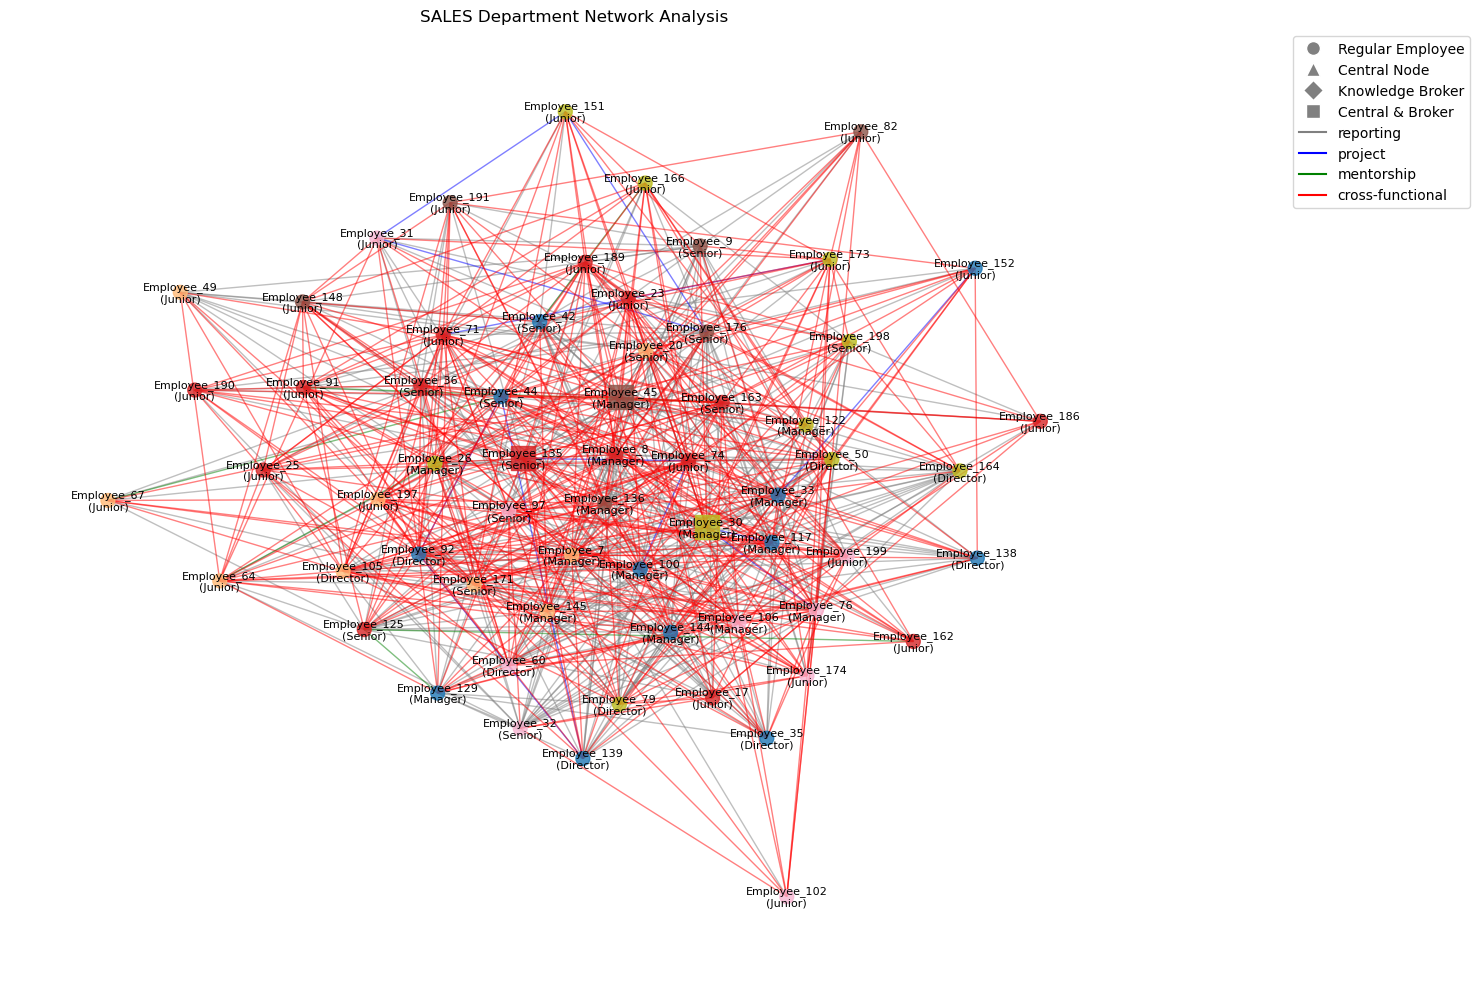


SALES Department Analysis:

Central Nodes (High Degree Centrality):
Employee_45 - Role: Manager - Years: 20
Employee_30 - Role: Manager - Years: 5
Employee_135 - Role: Senior - Years: 4

Knowledge Brokers (High Betweenness Centrality):
Employee_45 - Role: Manager - Years: 20
Employee_30 - Role: Manager - Years: 5
Employee_135 - Role: Senior - Years: 4

Cluster Analysis:

Cluster 2 - Size: 15
Role Distribution:
  Junior: 10 (66.7%)
  Senior: 4 (26.7%)
  Manager: 1 (6.7%)

Cluster 0 - Size: 12
Role Distribution:
  Manager: 5 (41.7%)
  Director: 4 (33.3%)
  Senior: 2 (16.7%)
  Junior: 1 (8.3%)

Cluster 5 - Size: 10
Role Distribution:
  Junior: 3 (30.0%)
  Manager: 3 (30.0%)
  Director: 3 (30.0%)
  Senior: 1 (10.0%)

Cluster 1 - Size: 9
Role Distribution:
  Junior: 4 (44.4%)
  Manager: 2 (22.2%)
  Senior: 2 (22.2%)
  Director: 1 (11.1%)

Cluster 4 - Size: 9
Role Distribution:
  Junior: 4 (44.4%)
  Senior: 2 (22.2%)
  Manager: 2 (22.2%)
  Director: 1 (11.1%)

Cluster 3 - Size: 7
Role Distr

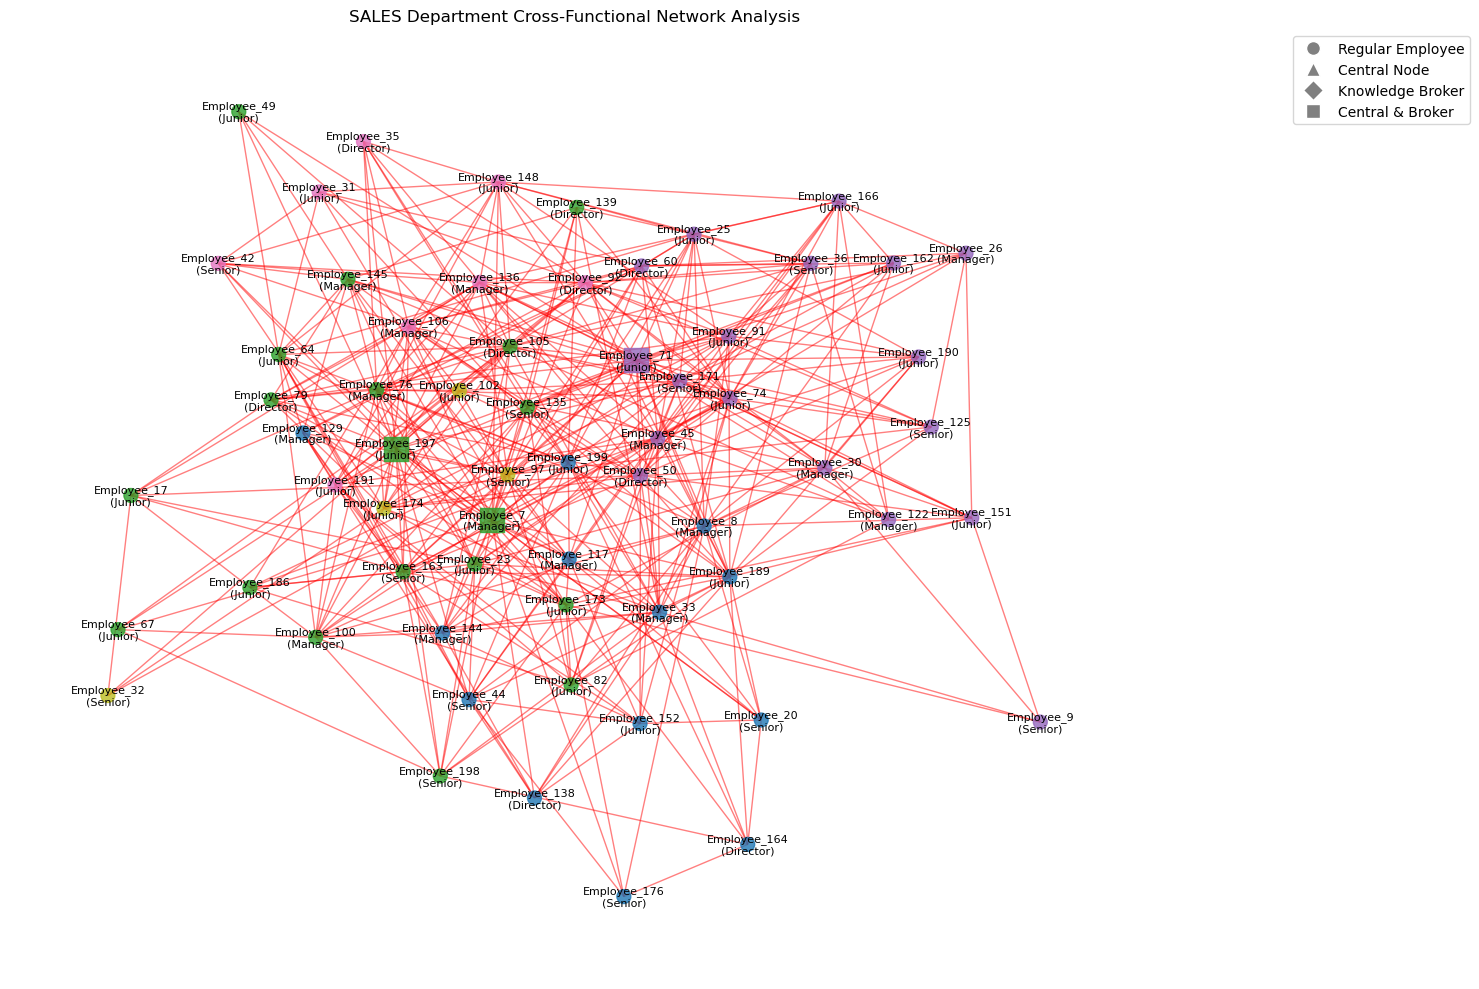


SALES Department Cross-Functional Network Analysis:

Central Nodes (High Degree Centrality):
Employee_7 - Role: Manager - Years: 14 - Skills: Leadership, Analytical, Creative
Employee_197 - Role: Junior - Years: 8 - Skills: Analytical, Leadership, Creative
Employee_71 - Role: Junior - Years: 19 - Skills: Technical, Leadership, Analytical

Knowledge Brokers (High Betweenness Centrality):
Employee_197 - Role: Junior - Years: 8 - Skills: Analytical, Leadership, Creative
Employee_71 - Role: Junior - Years: 19 - Skills: Technical, Leadership, Analytical
Employee_7 - Role: Manager - Years: 14 - Skills: Leadership, Analytical, Creative

Cluster Analysis:

Cluster 1 - Size: 19
Role Distribution:
  Junior: 9 (47.4%)
  Manager: 4 (21.1%)
  Senior: 3 (15.8%)
  Director: 3 (15.8%)
Skill Distribution:
  Analytical: 14 (73.7%)
  Leadership: 9 (47.4%)
  Communication: 9 (47.4%)
  Creative: 8 (42.1%)
  Technical: 3 (15.8%)

Cluster 2 - Size: 18
Role Distribution:
  Junior: 8 (44.4%)
  Senior: 4 (22.2

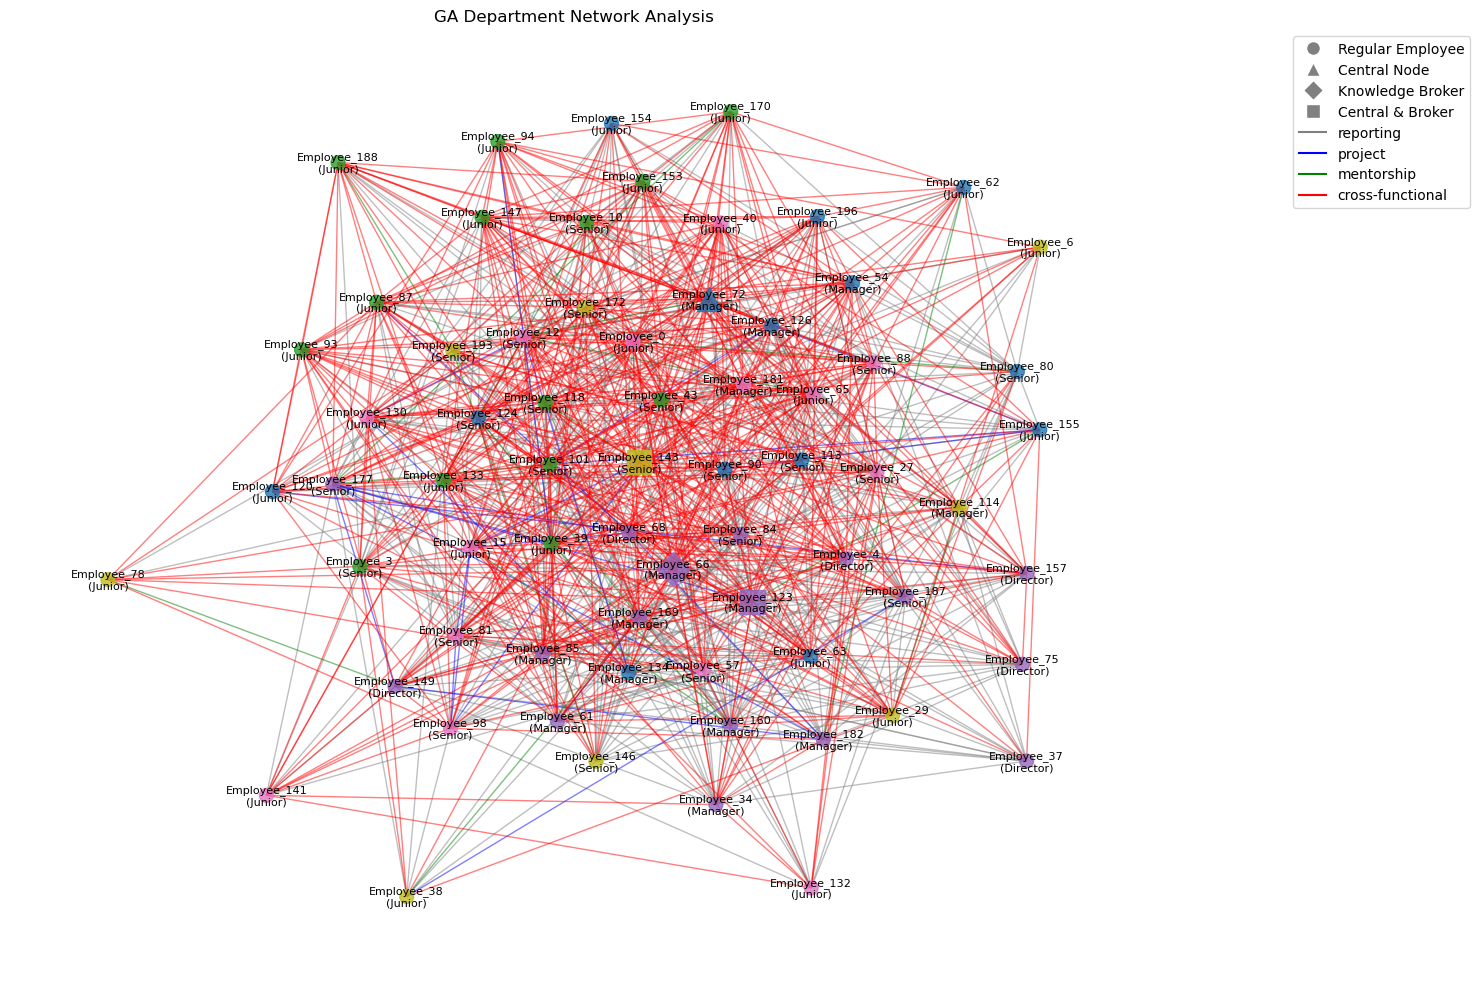


GA Department Analysis:

Central Nodes (High Degree Centrality):
Employee_72 - Role: Manager - Years: 6
Employee_123 - Role: Manager - Years: 8
Employee_143 - Role: Senior - Years: 3

Knowledge Brokers (High Betweenness Centrality):
Employee_66 - Role: Manager - Years: 10
Employee_123 - Role: Manager - Years: 8
Employee_143 - Role: Senior - Years: 3

Cluster Analysis:

Cluster 2 - Size: 17
Role Distribution:
  Manager: 8 (47.1%)
  Director: 6 (35.3%)
  Senior: 3 (17.6%)

Cluster 3 - Size: 14
Role Distribution:
  Junior: 7 (50.0%)
  Senior: 6 (42.9%)
  Manager: 1 (7.1%)

Cluster 1 - Size: 14
Role Distribution:
  Junior: 9 (64.3%)
  Senior: 5 (35.7%)

Cluster 0 - Size: 14
Role Distribution:
  Junior: 6 (42.9%)
  Manager: 4 (28.6%)
  Senior: 4 (28.6%)

Cluster 4 - Size: 9
Role Distribution:
  Junior: 4 (44.4%)
  Senior: 4 (44.4%)
  Manager: 1 (11.1%)

Relationship Type Analysis:
Reporting: 368
Project: 25
Mentorship: 19
Cross-functional: 525


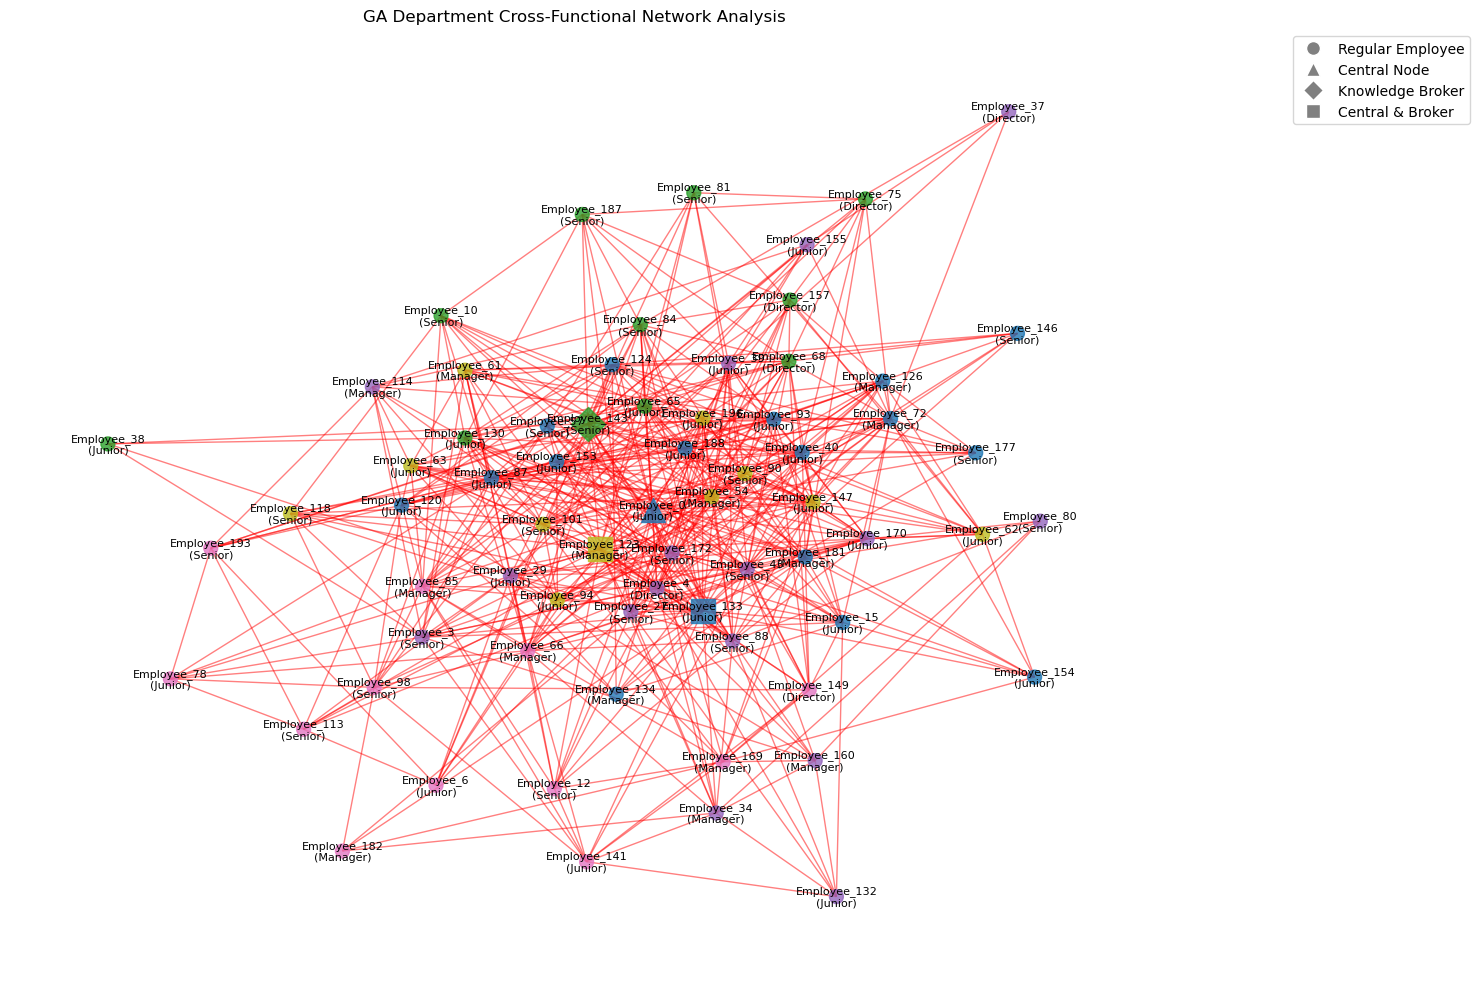


GA Department Cross-Functional Network Analysis:

Central Nodes (High Degree Centrality):
Employee_0 - Role: Junior - Years: 17 - Skills: Creative, Leadership, Technical
Employee_123 - Role: Manager - Years: 8 - Skills: Leadership, Creative, Communication
Employee_133 - Role: Junior - Years: 11 - Skills: Technical, Leadership, Analytical

Knowledge Brokers (High Betweenness Centrality):
Employee_123 - Role: Manager - Years: 8 - Skills: Leadership, Creative, Communication
Employee_133 - Role: Junior - Years: 11 - Skills: Technical, Leadership, Analytical
Employee_143 - Role: Senior - Years: 3 - Skills: Communication, Creative, Analytical

Cluster Analysis:

Cluster 0 - Size: 18
Role Distribution:
  Junior: 10 (55.6%)
  Manager: 4 (22.2%)
  Senior: 4 (22.2%)
Skill Distribution:
  Technical: 15 (83.3%)
  Creative: 9 (50.0%)
  Analytical: 6 (33.3%)
  Leadership: 4 (22.2%)
  Communication: 4 (22.2%)

Cluster 2 - Size: 16
Role Distribution:
  Senior: 6 (37.5%)
  Junior: 5 (31.2%)
  Manager:

In [3]:
import networkx as nx
import sqlite3
import time
from collections import defaultdict
from employee_graph import generate_employees, create_company_graph

# Function to create a SQLite database
def create_database(employees):
    conn = sqlite3.connect(':memory:')
    c = conn.cursor()
    
    # Create tables
    c.execute('''CREATE TABLE employees
                 (id INTEGER PRIMARY KEY, name TEXT, department TEXT, years_experience INTEGER, role TEXT)''')
    c.execute('''CREATE TABLE skills
                 (employee_id INTEGER, skill TEXT, 
                 FOREIGN KEY(employee_id) REFERENCES employees(id))''')
    c.execute('''CREATE TABLE relationships
                 (employee1_id INTEGER, employee2_id INTEGER, relationship TEXT,
                 FOREIGN KEY(employee1_id) REFERENCES employees(id),
                 FOREIGN KEY(employee2_id) REFERENCES employees(id))''')
    
    # Insert data
    for employee in employees:
        c.execute("INSERT INTO employees VALUES (?, ?, ?, ?, ?)", 
                  (employee['id'], employee['name'], employee['department'], 
                   employee['years_experience'], employee['role']))
        for skill in employee['skills']:
            c.execute("INSERT INTO skills VALUES (?, ?)", (employee['id'], skill))
    
    conn.commit()
    return conn

# Function to populate relationships in the database
def populate_relationships(conn, G):
    c = conn.cursor()
    for u, v, data in G.edges(data=True):
        c.execute("INSERT INTO relationships VALUES (?, ?, ?)", (u, v, data['relationship']))
    conn.commit()

# Demonstration functions
def graph_find_team_members(G, employee_id, max_depth=2):
    team = set()
    for depth in range(1, max_depth + 1):
        neighbors = set(nx.single_source_shortest_path(G, employee_id, cutoff=depth).keys())
        team.update(neighbors)
    team.remove(employee_id)  # Remove the employee themselves
    return team

def db_find_team_members(conn, employee_id, max_depth=2):
    c = conn.cursor()
    team = set()
    to_visit = {(employee_id, 0)}
    visited = set()

    while to_visit:
        current_id, depth = to_visit.pop()
        if current_id in visited or depth > max_depth:
            continue
        visited.add(current_id)
        if current_id != employee_id:
            team.add(current_id)
        
        if depth < max_depth:
            c.execute("""
                SELECT employee1_id, employee2_id FROM relationships 
                WHERE employee1_id = ? OR employee2_id = ?
            """, (current_id, current_id))
            for e1, e2 in c.fetchall():
                next_id = e2 if e1 == current_id else e1
                to_visit.add((next_id, depth + 1))
    
    return team

def graph_find_skill_clusters(G):
    skill_groups = defaultdict(list)
    for node, data in G.nodes(data=True):
        for skill in data['skills']:
            skill_groups[skill].append(node)
    return skill_groups

def db_find_skill_clusters(conn):
    c = conn.cursor()
    c.execute("SELECT employee_id, skill FROM skills")
    skill_groups = defaultdict(list)
    for employee_id, skill in c.fetchall():
        skill_groups[skill].append(employee_id)
    return skill_groups

def graph_find_central_employees(G):
    return sorted(nx.betweenness_centrality(G).items(), key=lambda x: x[1], reverse=True)[:5]

def db_find_central_employees(conn):
    c = conn.cursor()
    c.execute("""
        SELECT employee1_id, COUNT(*) as connections 
        FROM relationships 
        GROUP BY employee1_id
        UNION ALL
        SELECT employee2_id, COUNT(*) as connections 
        FROM relationships 
        GROUP BY employee2_id
    """)
    employee_connections = defaultdict(int)
    for employee_id, connections in c.fetchall():
        employee_connections[employee_id] += connections
    return sorted(employee_connections.items(), key=lambda x: x[1], reverse=True)[:5]

# Main demonstration
def run_demonstration():
    num_employees = 200
    employees = generate_employees(num_employees)
    
    print("Creating graph network and database...")
    G = create_company_graph(employees)
    conn = create_database(employees)
    populate_relationships(conn, G)
    
    print("\nDemonstration 1: Finding team members")
    employee_id = employees[0]['id']  # Use the first employee for demonstration
    
    start_time = time.time()
    graph_team = graph_find_team_members(G, employee_id)
    graph_time = time.time() - start_time
    
    start_time = time.time()
    db_team = db_find_team_members(conn, employee_id)
    db_time = time.time() - start_time
    
    print(f"Graph network found {len(graph_team)} team members in {graph_time:.4f} seconds")
    print(f"Database found {len(db_team)} team members in {db_time:.4f} seconds")
    
    print("\nDemonstration 2: Finding skill clusters")
    start_time = time.time()
    graph_skills = graph_find_skill_clusters(G)
    graph_time = time.time() - start_time
    
    start_time = time.time()
    db_skills = db_find_skill_clusters(conn)
    db_time = time.time() - start_time
    
    print(f"Graph network found skill clusters in {graph_time:.4f} seconds")
    print(f"Database found skill clusters in {db_time:.4f} seconds")
    
    print("\nDemonstration 3: Finding central employees")
    start_time = time.time()
    graph_central = graph_find_central_employees(G)
    graph_time = time.time() - start_time
    
    start_time = time.time()
    db_central = db_find_central_employees(conn)
    db_time = time.time() - start_time
    
    print(f"Graph network found central employees in {graph_time:.4f} seconds")
    print(f"Database found central employees in {db_time:.4f} seconds")
    
    print("\nTop 5 central employees (Graph Network):")
    for employee_id, centrality in graph_central:
        employee = G.nodes[employee_id]
        print(f"Employee {employee['name']} (ID: {employee_id}), Role: {employee['role']}, Centrality: {centrality:.4f}")
    
    print("\nTop 5 central employees (Database):")
    for employee_id, connections in db_central:
        c = conn.cursor()
        c.execute("SELECT name, role FROM employees WHERE id = ?", (employee_id,))
        name, role = c.fetchone()
        print(f"Employee {name} (ID: {employee_id}), Role: {role}, Connections: {connections}")
    
    conn.close()

if __name__ == "__main__":
    run_demonstration()